In [2]:
%%capture
!pip install -Uqq fastai gradio
!apt-get install tree

Introduction to Modern CNNs: ResNet and Transfer Learning

In past lessons, we created simple convolutional neural nets. In this module, we'll learn about more modern architectures like ResNet. Many of these architectures are also pre-trained on tasks like ImageNet, a 1000-class image classification problem. Using a technique called transfer learning, we can take parameters learned for one task and apply them to another task.

In this lesson, we'll introduce a few fundamental concepts in modern deep learning:

Transfer learning: We will use parameters trained with one task for a diffent task. We'll use a ResNet backbone trained on ImageNet, a task for classifing 1,000 different categories of images.
Residual connections: We do a deep dive into ResNet (mentioned above). We'll implement a simple residual network and do an experiment comparing it to a network without residual connections.

In [3]:
from fastai.vision.all import *
from fastai import *
from torch import nn, optim
import torch

from IPython.display import display, YouTubeVideo

In [4]:
SIZE = {'width':1000, 'height': 600}

Data Preparation

In this module, we'll be working with the pets dataset. This dataset contains 37 different types of pet breeds, which is a much harder task than classifying digits!

In the cells below, we'll load and inspect items in the pets dataset. First, let's download the data.

In [5]:
path = untar_data(URLs.PETS)

What's in the data directory? It looks like there's an images folder and an annotations folder. For this module, we'll just be using the images folder (annotations is for object localization, a more advanced task).

In [6]:
list(path.ls())

[Path('/root/.fastai/data/oxford-iiit-pet/annotations'),
 Path('/root/.fastai/data/oxford-iiit-pet/images')]

Let's take a look at what's in the images folder. Below, we sample 10 file names from the images folder. It looks like the file names are in the format of {breed}_{number}.jpg

In [7]:
!tree {str(path/'images')} | grep .jpg | shuf -n 10

├── Bombay_180.jpg
├── beagle_158.jpg
├── english_setter_102.jpg
├── Sphynx_80.jpg
├── german_shorthaired_83.jpg
├── beagle_189.jpg
├── american_bulldog_60.jpg
├── Egyptian_Mau_77.jpg
├── yorkshire_terrier_162.jpg
├── Ragdoll_141.jpg


To build our data loaders, we'll create a function that applies a label to each item using the filename.

In [8]:
def label_func(filename):
    return '_'.join(filename.split('_')[:-1])

Then, we can use the ImageDataLoaders.from_name_func class method to generate our dataloaders. As you can see, we've added a few transforms that resize the images to 224x224 and normalize them. Since there's a whole course on using fastai, we won't cover the internals of what this is doing. For more information and detailed examples, see this documentation and this tutorial.

In [9]:
dls = ImageDataLoaders.from_name_func(
    path=path,
    fnames=get_image_files(path/'images'),
    label_func=label_func,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

What's Normalize.from_stats(*imagenet_stats) doing? Up until now, we've been scaling our images between 0 and 1. While this has worked decently for greyscale images, it is not the best strategy for color images. Different color channels have different distributions in images, so we should scale each channel differently. Instead of min/max scaling, we'll now standardize using the mean and standard deviation of each channel.

imagenet_stats, shown below, contains the mean and standard deviation for the Imagenet dataset, which is currently around 14 million images. We add a transform that uses these stats to scale each channel independently. When working with pre-trained models, it's important to use the center and scale of the data the model was trained on for transfer learning so it receives data in the ranges it's accustomed to. Data that differs significsantly from that range can result in unstable training.

In [10]:
imagenet_stats    #media y desviacion por cada canal

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Finally, lets' take a look at a batch of the data to observe what we'll be working with.

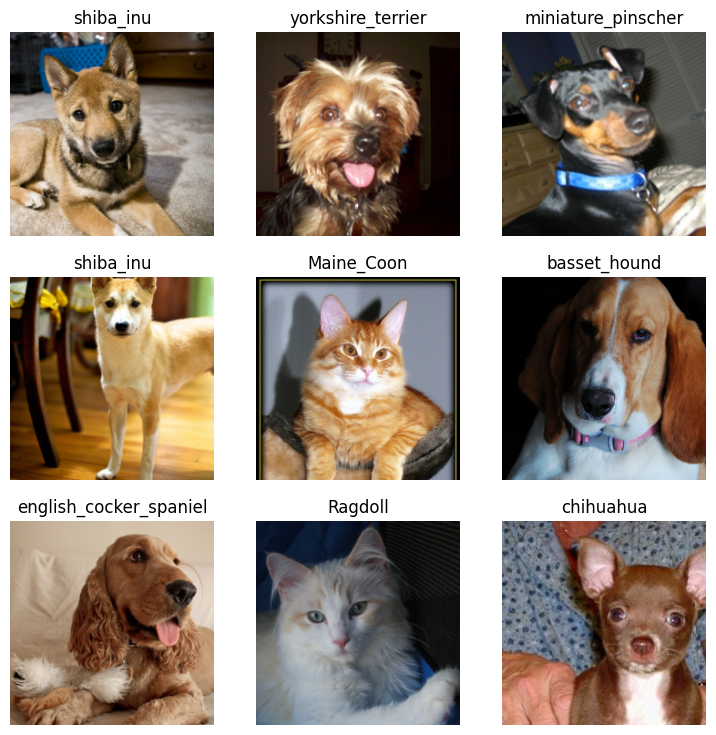

In [11]:
dls.show_batch()

Introduction to ResNet

In this module, we'll be using ResNet for transfer learning. In this lesson, we'll go through a brief introduction to ResNets and why they work. In a later lesson, there will be an optional deep dive where we build a ResNet from scratch.

What is a ResNet?
The "Res" in ResNet stands for residual connections, also called skip connections. These residual connections represent an advance in deep learning that allowed networks to get much deeper by helping address a problem called degradation. Here is a description of degradation from the original ResNet paper:

When deeper networks are able to start converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error, as reported in and thoroughly verified by our experiments.

[1]

In short, we'd expect adding more layers/parameters to help us learn the training data better.

In practice, we actually see performance on the training set degrade with additional layers in deep NNs.

ResNets offer a solution to this problem.

Let's take a look at the architecture of a ResNet, shown below. Previously, the outputs of a layer feed directly into the next layer. In ResNets, the outputs of some layers feed into the next layer, but also "skip" a few layers as well.



How does this help solve the vanishing gradient problem? Let's take a closer look at one of the skip connections. The figure below illustrates what the residual layer is doing.



Why do ResNets work?
The paper Residual Networks Behave Like Ensembles of Relatively Shallow Networks [2] describes a relatively intuitive explanation for why ResNets work so well. The first idea is, as the paper states, residual connections turn a neural network into an ensemble of sorts. For example, a signal from the input could travel only through skip connections and reach the output in relatively few steps. This is a short path. Alternately, the signal from the input could travel through many layers, resulting in a longer path. In reality, there are many pathways for the data to travel through the network. This allows signal from layers closer to the input to persist, while being refined by layers closer to the output. The paper also observes that longer paths receive larger gradient updates than shorter paths. From the paper:

Surprisingly, almost all of the gradient updates during training come from paths between 5 and 17 modules long. These are the effective paths, even though they constitute only 0.45% of all paths through this network.

[2]

Intuitively, this helps the gradient reach the layers closer to the input more directly through skip connections. One may also intuit that residual connections help solve the vanishing gradient problem. This actually is not the case - since most updates occur through shorter paths, the updates to long paths are relatively small, so the gradients could still become small through long paths in a residual neural net.

In this lesson, we were introduced to the concept of residual connections and ResNets. If you want to understand residual connections in more detail, we implement a residual conv block in the last lesson of this module. This chapter from FastAI's book [3] does a great deep dive into ResNets. Additionally, here is a great video that explains the logic behind ResNets:

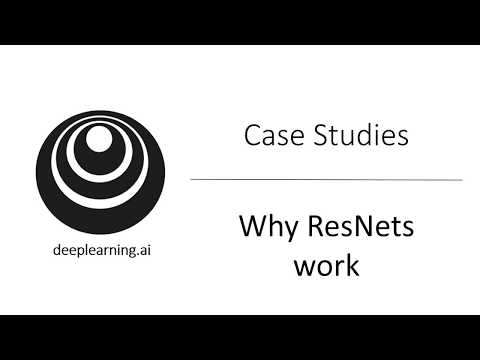

In [12]:
vid = YouTubeVideo('RYth6EbBUqM', **SIZE)
display(vid)

If you want some additional intuition for how skip-connections helped ResNet improve over previous architectures, read Visualizing the Loss Landscape of Neural Nets [5]. They show that adding skip-connections actually smooths the "landscape" of the loss function to improve the optimization process. That is, there are fewer local minima to get stuck in, and optimizers can more easily find global minima. Figure 1 from the paper below is a great illustration of this.

Baseline: How well do we do with randomly initialized parameters?
In this lesson, we'll train a ResNet initialized with random parameters using fastai. We want to understand how well the model performs with random parameters so we can compare the performance on the same dataset with pre-trained parameters.

NOTE: We've created FastAI learners before. cnn_learner is a convenience function that creates a learner for image classification. For more info on cnn_learner, please see the documentation and this book chapter [3].

In [13]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architechture you want to use
    pretrained=False, # Tell it NOT to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ust as a sanity check, let's see what performance we might expect with random chance.

In [14]:
print(f"""
There are {learn.dls.c} categories.
If we guessed randomly, we would have aboiut a {100. * 1/learn.dls.c:.02f}% chance of guessing correctly.
""")


There are 37 categories.
If we guessed randomly, we would have aboiut a 2.70% chance of guessing correctly.



Let's train our model for 5 epochs and record the performance on the validation set.

In [15]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.622118,5.042265,0.060217,0.939784,01:10
1,4.190690,3.554400,0.088633,0.911367,00:49
2,3.807063,3.206073,0.158322,0.841678,00:48
3,3.547783,2.938752,0.188769,0.811231,00:50
4,3.287452,2.848728,0.221245,0.778755,00:47


After 5 epochs, we achieved an accuracy over 37 categories of about 0.2. While this is better than random chance, we can do better by using a model backbone that's aleady learned about the visual world. In the next lesson, we'll try just that.

Transfer Learning: ResNet pre-trained on ImageNet

In the past, we've trained models with randomly initialized parameters. In this lesson, we'll perform transfer learning, or the practice of using parameters trained on one task to perform another task.

So what happens when we transfer learn? First, we download the parameters from a pre-trained model. In this case, we'll be using the 34-layer ResNet, same as the previous lesson.

The model we will download was trained on ImageNet, which has 1,000 categories, which means the output layer of the model will have 1,000 outputs. We only have 37 in this task, and the categories are different. To address this, we will strip off the final classification layer from the network, and replace it with an untrained linear classifier with 37 categories.

The next step is freezing the weights of the backbone. The backbone is every part of the model we downloaded except the final classification layer. Since there is a lot of knowledge distilled in the backbone, we don't want to update those parameters very much. Once we freeze the backbone, the only parameters that will receive updates are the parameters of the final classification layer.

Finally, we can fine tune our model. First, we will train for a few epochs, but only update the weights of our classification head. Then, we will unfreeze all the parameters, and train the whole network together. We will do this using discriminative learning rates, where layers closer to the input are trained with a smaller learning rate than those closer to the output. The intuition behind this is that the model "remembers" more basic features like edges, but re-learns more complex features that help discriminate different classes.

In the cell below, we load the pre-trained model and replace the classification head with our un-trained head.

In [16]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architechture you want to use
    pretrained=True, # Tell it to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.9MB/s]


What does this head look like? The head is the last module in the model. It contains an adaptive pooling layer, then two-layer fully-connected network with 37 outputs.

In [17]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In the cell block below, we train our classifier head for just one epoch. We can see that, without even fine-tuning the parameters in the backbone, we already blow our previous classifier out of the water! This is because our model backbone already "knows" a lot about the visual world and can extract features that are really useful for classification on a totally different dataset.

In [18]:
LR = 1e-3

In [19]:
# Train the classifier head
learn.fit_one_cycle(1, LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.185173,0.329078,0.905277,0.094723,00:45


Now that we've trained our classifier a bit, let's unfreeze all our parameters and train all the parameters. The .unfreeze() method unfreezes the parameters that were previously frozen, so they will receive updates as well.

In [20]:
# Unfreeze the backbone
learn.unfreeze()

In [21]:
# Trainin everything together
learn.fit_one_cycle(5, lr_max=slice(LR/10, LR))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.567362,0.528090,0.843708,0.156292,00:48
1,0.547386,0.533550,0.844384,0.155616,00:47
2,0.333309,0.370306,0.890392,0.109608,00:47
3,0.148552,0.259676,0.923545,0.076455,00:47
4,0.064654,0.246872,0.928958,0.071042,00:48


Fastai also provides a method that combines the last 3 cells called fine_tune.

In [22]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    resnet34, # Specify the architechture you want to use
    pretrained=True, # Tell it to fetch the ImageNet weights
    # loss_func=nn.CrossEntropyLoss(), # Pass the loss function
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

In [23]:
learn.fine_tune(5, base_lr=LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.998316,0.352223,0.887010,0.112991,00:45


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.554150,0.250938,0.919486,0.080514,00:47
1,0.353969,0.255960,0.916779,0.083221,00:47
2,0.210517,0.227918,0.930988,0.069012,00:48
3,0.120128,0.220050,0.931664,0.068336,00:53
4,0.088338,0.217310,0.933694,0.066306,00:46


In this lesson, we fine-tuned a model that was pre-trained on ImageNet to classify different breeds of pets. With the same CNN architecture, we saw much improved results after relatively little training time. For the randomly initialized model, we got an accuracy of about 20% after 5 epochs, relative to a 94% accuracy after the same number of epochs using transfer learning. To read more about transfer learning and fine tuning using FastAI, please see the following sections in this book chapter [4]:

Unfreezing and Transfer Learning
Discriminative Learning Rates
In the next lesson, we will get a small taste of model serving by deploying the model we trained behind a user interface (UI).

A small taste of model serving with GradIO

Many are curious what it means to take a model and put it into production. We will get our first taste of that here. Production can mean a lot of things, but in general it means to make the model usable by others. This is done many ways, including:

Collecting data throughout the day and making inferences on that data periodically in batches
Creating a REST API that wraps a prediction function so other software or microservices can make requests of that service
Putting the model behind a UI so users can directly interact with that model
We will explore these scenarios in the production chapter of this course, but in this lesson we'll see that deployment can actually be pretty simple.

When working with other team members like engineers, designers, or product managers, it's great to give them a tool to examine the inputs and outputs to a model. It's really useful to provide a simple yet intuitive interface where individuals can examine model inputs and outputs. Today, we'll perform a simple example of that using gradio.

In [24]:
import gradio as gr

The first thing we have to do is build a function that takes in an image and returns inferences about that image. Let's examine how to use our fastai model to predict on an image.

TensorCategory(25)


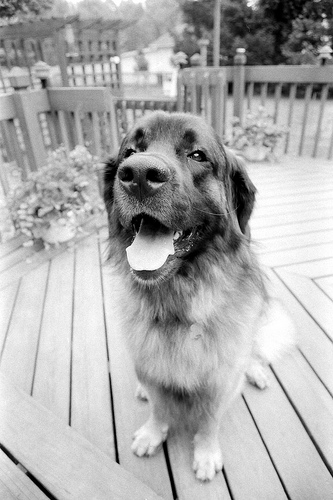

In [25]:
# grab one image from our training dataset
img, cat = dls.train_ds[0]
print(cat)
img

Then, let's pass that image through our learner's predict function. We can see that we get back a tuple of category name, category id, and normalized logits.

In [26]:
breed, cat_id, logits = learn.predict(img)
print(breed, cat_id, sep='\n')
print(logits.sum())

leonberger
tensor(25)
tensor(1.)


Using this knowledge, let's create a function that takes in an image and returns a string with information about our inference.

In [27]:
def recognize_pet(img):
    breed, cat_id, logits = learn.predict(img)
    proba = float(logits.softmax(dim=0).max())
    return f"""
    Breed: {breed},
    Probability: {proba:.04f}
    """

print(recognize_pet(img))


    Breed: leonberger,
    Probability: 0.0697
    


Now that we have this function, we can use it in our UI. gr.Interface is a class that wraps a predict function. It also allows you to define the types of inputs and outputs so that they align with the inputs and outputs to your prediction function. Let's run the example below.

NOTE: The example doesn't render in the course content, make sure to complete the exercise below to run your own model server right in the notebook.

# Exercise 12.1

Run the block of code below.
Find a few images of pets to upload and observe the inferences made by the model.
Do they work decently well?

<!-- startquestion -->

In [28]:
gr.Interface(recognize_pet, inputs=gr.inputs.Image(source='upload'), outputs=gr.outputs.Label()).launch(inline=True)

<ipython-input-28-15ab6fc2cd6c>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.Interface(recognize_pet, inputs=gr.inputs.Image(source='upload'), outputs=gr.outputs.Label()).launch(inline=True)
<ipython-input-28-15ab6fc2cd6c>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.Interface(recognize_pet, inputs=gr.inputs.Image(source='upload'), outputs=gr.outputs.Label()).launch(inline=True)
<ipython-input-28-15ab6fc2cd6c>:1: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  gr.Interface(recognize_pet, inputs=gr.inputs.Image(source='upload'), outputs=gr.outputs.Label()).launch(inline=True)
<ipython-input-28-15ab6fc2cd6c>:1: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Optional: Building a ResNet from Scratch
Let's see if we can gain some intuition about what ResNet is. Previous architectures like VGG were composed of blocks of convolutional layers, where the top layers had more spatial features but fewer channels; the deeper layers had more channels but less spatial information. Pooling was used to reduce spatial information.

When VGG was popular, deep NNs suffered a lot from the vanishing gradient problem, and weight updates wouldn't reach the bottom layers of the network. ResNet solved this with a concept called the residual block. From the input, it passes the identity every few layers, so that when gradients are calculated, they can "skip" to the top layers, allowing these networks to get much, much deeper.

Let's create our own residual block so we can understand what's going on. We won't deal with any shape changes, but will implement the rest.

In [29]:
def conv_block(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(0.2)
    )

Now let's create a residual conv block. This block has two conv_block layers. As seen in the forward method, we add the identity of the input to the outputs of the two-layer CNN, then pass that sum through the activation function.

You may have asked yourself what happens when the number of channels in the input doesn't match the number of channels in the output? How might we add a tensor of shape (batch_size, 16, 244, 244) to a tensor of (batch_size, 32, 244, 244)? This is what the projection is doing. It uses a 1x1 conv to expand the number of feature maps from the number of input channels to the number of output channels. It also uses the same stride as the first conv block. This way, we can add the two tensors without any shape mismatches.

In [30]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # If the channels or output shape are different,
        # we need a projection so the channels match
        self.projection = True if in_channels != out_channels or stride > 1 else False
        # The projection is just a 1x1 convolutional layer that changes
        # the number of channels to match out_channels.
        if self.projection:
            self.proj = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                padding=0,
                stride=stride # If the shape changes, this is one way to downsample spatially.
            )

        # Now just add the easy part of the network
        self.conv1 = conv_block(in_channels, out_channels, stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.final_act = nn.PReLU()

    def forward(self, x):
        # Declare the identity
        identity = x
        # but if we need to do the projection, project x
        # into a different number of channels.
        if self.projection:
            identity = self.proj(x)
        # Pass the original x through the conv network
        acts = self.conv2(self.conv1(x))
        # Return the identity + the activations of the conv network
        return self.final_act(identity + acts)

Now that we've created our residual block, let's create a fake batch of data and pass it through the block. Below, our fake_batch is a tensor with a batch_size of 2, 32 channels, and a height and width of 28 pixels.

In [31]:
fake_batch = torch.randn(2, 32, 28, 28)

Next, let's instantiate our residual block. For now, let's just return the same number of channels. We can see that there are two convolutioanl blocks comprising conv ➡ activation ➡ batch norm ➡ dropout, and a final activation that acts on the sum of the input to the block and the output of the conv2 block.

In [32]:
res = ResidualConvBlock(32, 32)
res

ResidualConvBlock(
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

Now let's pass our image-like fake batch through the layer. We can see the shape is identical to the input

In [33]:
res(fake_batch).shape

torch.Size([2, 32, 28, 28])

Now let's examine a residual block with a projection layer. Let's set output to 64 instead of 32 feature maps. We can see that there is also a proj layer that performs 1x1 convolutions with to project the 32-channel convolutional inptus into 64-channel outputs. Our inputs will be passed through this projection layer before being added to the outputs of conv2 before being passed through the final activation function. For some more intuition on 1x1 convolutions and how they work, please check out this video.

In [34]:
res = ResidualConvBlock(32, 64)
res

ResidualConvBlock(
  (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

In [35]:
res(fake_batch).shape

torch.Size([2, 64, 28, 28])

Finally, let's change the height and width of the output by adding a stride. If we create a ResidualConvBlock with a stride of 2, we can see that the stride of both the convolutional layer in conv1 and proj are both 2. This way, the dimensionality of projected inputs and the outputs of conv2 will match.

In [36]:
res = ResidualConvBlock(32, 64, 2)
res

ResidualConvBlock(
  (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

In [37]:
res(fake_batch).shape

torch.Size([2, 64, 14, 14])

Can we use our ResidualConvBlock to make a ResNet that will learn? Let's use our block to create a custom ResNet. First, let's create a function that returns a model that uses the residual block we created.

NOTE: The author just threw this model together, without any experimentation with regard to the number of filters, amount of pooling, number of layers, etc. We just want to learn whether our residual block can learn - that is, perform better than random chance on the validation dataset.

In [38]:
def build_model(*args, **kwargs):
    model = nn.Sequential(
        nn.BatchNorm2d(3),
        ResidualConvBlock(3, 16),
        ResidualConvBlock(16,16),
        ResidualConvBlock(16,32,2),
        ResidualConvBlock(32, 64),
        nn.AdaptiveMaxPool2d(1),
        nn.Flatten(),
        nn.Linear(64, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 37)
    )
    return model

Next, let's create a learner object from our model and the dataloaders we used in the past.

In [39]:
learn = cnn_learner(dls, build_model, pretrained=False, metrics=[accuracy, error_rate])

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Finally, let's train for 20 epochs using a one cycle policy.

In [40]:
learn.fit_one_cycle(20, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.979519,5.351747,0.025034,0.974966,00:55
1,4.789432,4.676459,0.023681,0.976319,00:56
2,4.564041,4.292473,0.037889,0.962111,00:58
3,4.297719,3.987335,0.043302,0.956698,00:56
4,4.145039,4.081278,0.054127,0.945873,00:57
5,3.972347,3.773697,0.056834,0.943166,00:57
6,3.801822,3.716337,0.067659,0.932341,00:58
7,3.695217,3.624184,0.070365,0.929635,00:56
8,3.628838,3.713169,0.056834,0.943166,00:57
9,3.492927,3.400318,0.097429,0.902571,00:56


While we didn't match the performance of the resnet from the previous lesson, we were able to out-perform random chance. This is expected, since we used ResNet 34, which has many more parameters than the model we built here. Feel free to experiment with the model returned by buiild_model to see if you can improve the performance!

In this lesson, we implemented a residual block in pure torch and trained it using FastAI. You should now have a relatively good understanding of residual connections in neural networks.